## DATASET LOOKUP

In [1]:
import os

DATASET_DIR = "./dataset/"
TRAIN_DIR = "asl_alphabet_train"
TEST_DIR = "asl_alphabet_test"

## MEDIAPIPE TEST

In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Inicjalizacja MediaPipe
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

def process_image(image_path):
    try:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB
        
        # Initialize the Hand Detector
        with mp_hands.Hands(
            static_image_mode=True, # Image - not a video
            max_num_hands=1,
            min_detection_confidence=0.5
            ) as hands:
            results = hands.process(image_rgb)
            
            # If a hand is detected draw points and lines on the oplot
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Rysowanie punktów i połączeń
                    mp_draw.draw_landmarks(
                        image_rgb,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_draw.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=1),
                        mp_draw.DrawingSpec(color=(0, 0, 255), thickness=2)
                    )
                    
                    # Adding numbers to points
                    # for id, landmark in enumerate(hand_landmarks.landmark):
                    #     height, width, _ = image_rgb.shape
                    #     cx, cy = int(landmark.x * width), int(landmark.y * height)
                    #     cv2.putText(image_rgb, str(id), (cx, cy), 
                    #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            
                return image_rgb
            
            else: return None
            
    
    except Exception as e:
        print(f"Error processing image: {image_path}: {str(e)}")
        return None


Another test Image

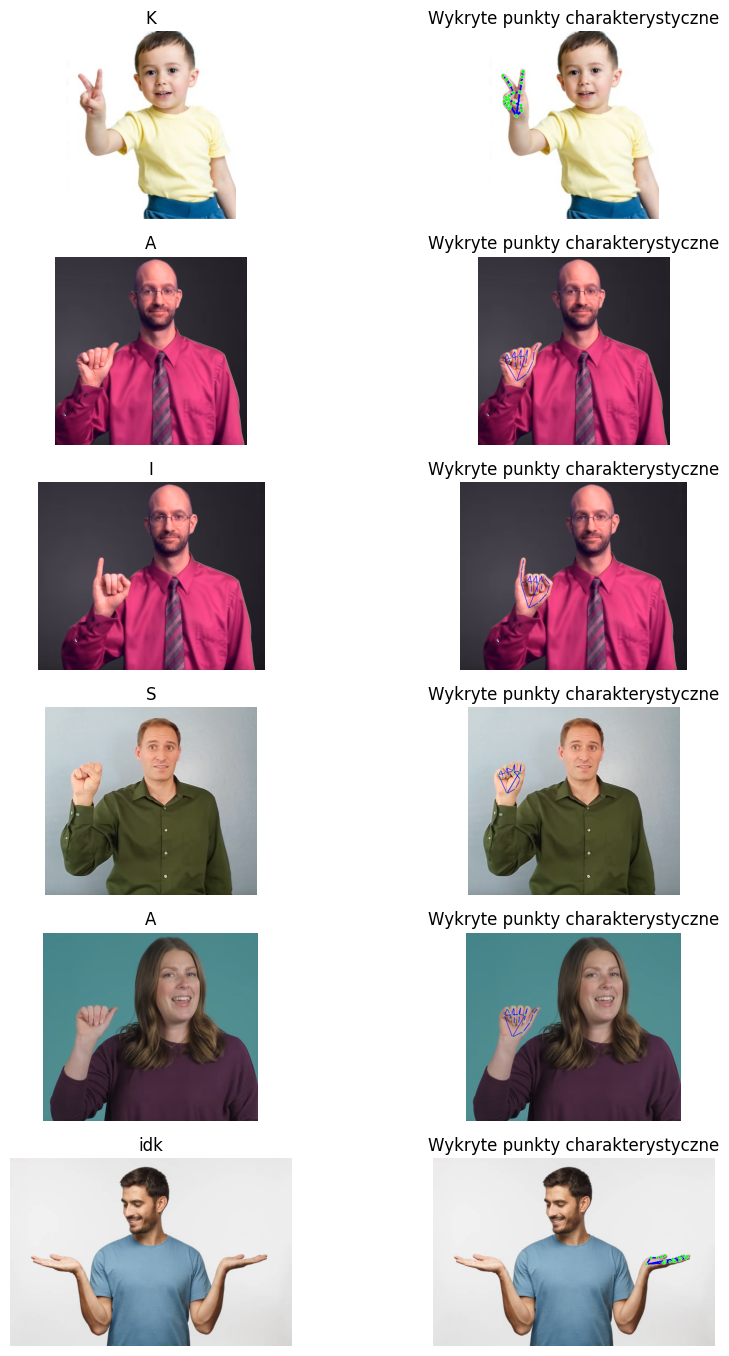

In [3]:
# Test mediapipe
num_images = 7
labels = ["K", "A", "I", "S", "A", "idk"]

plt.figure(figsize=(10, 20))
for idx, label in enumerate(labels):
    img_path = DATASET_DIR + f"test_images/test_image#{idx+1}.png"
    # Oryginalny obraz
    original_img = Image.open(img_path)
    plt.subplot(num_images, 2, 2*idx+1)
    plt.title(label)
    plt.imshow(original_img)
    plt.axis('off')

    # Obraz z wykrytymi punktami charakterystycznymi
    processed_img = process_image(img_path)
    plt.subplot(num_images, 2, 2*idx+2)

    if processed_img is not None:
        plt.title('Wykryte punkty charakterystyczne')
        plt.imshow(processed_img)
        plt.axis('off')
    else:
        plt.title('Nie wykryto punktów charakterystycznych')
        plt.imshow(original_img)
        plt.axis('off')

plt.show()

# crop_hand, ktory zwraca tylko zdj reki

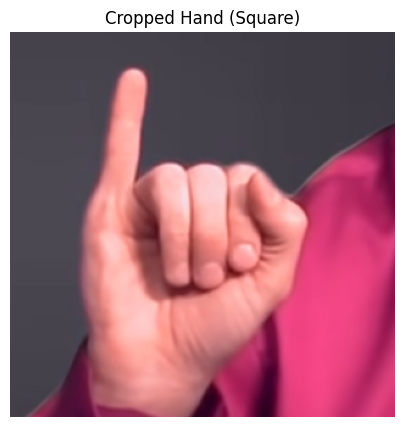

In [47]:
import cv2
import mediapipe as mp
import numpy as np

mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

# Function to crop hand region
def crop_hand(image_path):
    try:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Initialize the Hand Detector
        with mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=0.5
        ) as hands:
            results = hands.process(image_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Get the bounding box around the hand
                    h, w, _ = image.shape
                    x_min, y_min = w, h
                    x_max, y_max = 0, 0

                    for landmark in hand_landmarks.landmark:
                        x, y = int(landmark.x * w), int(landmark.y * h)
                        x_min = min(x_min, x)
                        y_min = min(y_min, y)
                        x_max = max(x_max, x)
                        y_max = max(y_max, y)

                    # Calculate padding as 0.01% of total pixels
                    total_pixels = h * w
                    padding = int(0.00004 * total_pixels)

                    x_min = max(x_min - padding, 0)
                    y_min = max(y_min - padding, 0)
                    x_max = min(x_max + padding, w)
                    y_max = min(y_max + padding, h)

                    # Ensure the cropped image is a square
                    box_width = x_max - x_min
                    box_height = y_max - y_min
                    diff = abs(box_width - box_height)

                    if box_width > box_height:
                        y_min = max(y_min - diff // 2, 0)
                        y_max = min(y_max + diff // 2, h)
                    else:
                        x_min = max(x_min - diff // 2, 0)
                        x_max = min(x_max + diff // 2, w)

                    # Crop the hand region
                    cropped_hand = image_rgb[y_min:y_max, x_min:x_max]

                    return cropped_hand
            else:
                return None

    except Exception as e:
        print(f"Error cropping hand in image: {image_path}: {str(e)}")
        return None

# Test the function
img_path = DATASET_DIR + "test_images/test_image#3.png"  # Replace with your image path
cropped_hand = crop_hand(img_path)

if cropped_hand is not None:
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_hand)
    plt.axis('off')
    plt.title('Cropped Hand (Square)')
    plt.show()
else:
    print("No hand detected or error cropping the image.")


# crop_hand, ktory zwraca zdj reki + wektory charakterystyczne (jako numpy array)

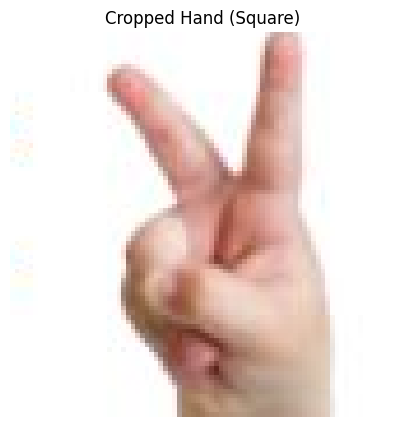

Characteristic Vectors (as numpy array):
[[ 1.61427528e-01  4.52151537e-01  5.34935680e-07]
 [ 1.90300867e-01  4.24655050e-01 -3.45642194e-02]
 [ 1.87603682e-01  3.94933224e-01 -4.83998060e-02]
 [ 1.47986457e-01  3.80027145e-01 -5.92927821e-02]
 [ 1.16306230e-01  3.64929289e-01 -6.82293177e-02]
 [ 1.81227669e-01  3.25173318e-01 -2.32175272e-02]
 [ 1.90164074e-01  2.76051581e-01 -4.57909070e-02]
 [ 1.96018457e-01  2.43042082e-01 -5.94871752e-02]
 [ 2.00389549e-01  2.15063900e-01 -6.58139363e-02]
 [ 1.45462677e-01  3.27826798e-01 -1.80900972e-02]
 [ 1.23324141e-01  2.84554332e-01 -4.26038913e-02]
 [ 1.01826042e-01  2.57715851e-01 -5.65142334e-02]
 [ 8.40695053e-02  2.35601366e-01 -5.98402917e-02]
 [ 1.19778983e-01  3.44066888e-01 -1.71885118e-02]
 [ 1.00405678e-01  3.52158338e-01 -5.43191284e-02]
 [ 1.12674981e-01  3.83185267e-01 -6.43016323e-02]
 [ 1.24811292e-01  4.02844638e-01 -5.72053567e-02]
 [ 1.03421822e-01  3.66000980e-01 -1.83286630e-02]
 [ 9.10095125e-02  3.73462170e-01 -4.5949

In [38]:
import cv2
import mediapipe as mp
import numpy as np

mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

# Function to crop hand region and return characteristic vectors
def crop_hand(image_path):
    try:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Initialize the Hand Detector
        with mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=0.5
        ) as hands:
            results = hands.process(image_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Get the bounding box around the hand
                    h, w, _ = image.shape
                    x_min, y_min = w, h
                    x_max, y_max = 0, 0

                    for landmark in hand_landmarks.landmark:
                        x, y = int(landmark.x * w), int(landmark.y * h)
                        x_min = min(x_min, x)
                        y_min = min(y_min, y)
                        x_max = max(x_max, x)
                        y_max = max(y_max, y)

                    # Calculate padding as 0.01% of total pixels
                    total_pixels = h * w
                    padding = int(0.00004 * total_pixels)

                    x_min = max(x_min - padding, 0)
                    y_min = max(y_min - padding, 0)
                    x_max = min(x_max + padding, w)
                    y_max = min(y_max + padding, h)

                    # Ensure the cropped image is a square
                    box_width = x_max - x_min
                    box_height = y_max - y_min
                    diff = abs(box_width - box_height)

                    if box_width > box_height:
                        y_min = max(y_min - diff // 2, 0)
                        y_max = min(y_max + diff // 2, h)
                    else:
                        x_min = max(x_min - diff // 2, 0)
                        x_max = min(x_max + diff // 2, w)

                    # Crop the hand region
                    cropped_hand = image_rgb[y_min:y_max, x_min:x_max]

                    # Extract characteristic vectors as a numpy array
                    characteristic_vectors = np.array(
                        [[landmark.x, landmark.y, landmark.z] for landmark in hand_landmarks.landmark]
                    )

                    return cropped_hand, characteristic_vectors
            else:
                return None, None

    except Exception as e:
        print(f"Error cropping hand in image: {image_path}: {str(e)}")
        return None, None

# Test the function
img_path = DATASET_DIR + "test_images/test_image#1.png"  # Replace with your image path
cropped_hand, characteristic_vectors = crop_hand(img_path)

if cropped_hand is not None:
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_hand)
    plt.axis('off')
    plt.title('Cropped Hand (Square)')
    plt.show()

    print("Characteristic Vectors (as numpy array):")
    print(characteristic_vectors)
else:
    print("No hand detected or error cropping the image.")

In [9]:
characteristic_vectors.shape

(21, 3)